 # ARIMA
ARIMA models (which include ARMA, AR and MA models) are a general class of models to forecast stationary time series. ARIMA models are made of three parts:
- A weighted sum of lagged values of the series (Auto-regressive (AR) part)
- A weighted sum of lagged forecasted errors of the series (Moving-average (MA) part)
- A difference of the time series (Integrated (I) part)

An ARIMA model is often noted ARIMA(p, d, q) where p represents the order of the AR part, d the order of differencing (“I” part), and q the order of the MA term.

[Link](https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788)
[link2](https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051)

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# mpl.rcParams['figure.figsize'] = (30, 8)
# mpl.rcParams['axes.grid'] = True
# plt.style.use('Solarize_Light2')


from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.api as sm
import statsmodels.tsa.seasonal as seasonal
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import kpss

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from evaluation import forecast_accuracy

In [2]:
def preprocess(dx):
    # only filter final DOA
    dx = dx[dx['DBA']==89]
    dx = dx.set_index('DOA')
    dx = dx.asfreq(freq='d', method='ffill')
    dx = dx.reset_index('DOA')
    # Normalize Rooms 
    dx.loc[dx['Rooms']==0,'Rooms'] = dx['Rooms'].max()
    # Normalize ROH 
    dx.loc[dx['ROH']==0,'ROH'] = dx['ROH'].median()

    # convert to OCC
    dx['ROH'] = dx['ROH']/dx['Rooms']
    dx.loc[dx['ROH']>1,'ROH'] = 1.0
    dx = dx.drop(columns=['DBA','LAR','ADR','Rooms'])
    dx = dx.set_index('DOA')
    dx = dx.asfreq(freq='D', method='ffill')
    return dx

def train_test_split(dx):
    index = int(len(dx)*0.8)
    train = dx[:index]
    test  = dx[index:]
    return train,test

In [3]:
df = pd.read_pickle('../dataset/preprocessed/48_imputed.pkl')
df = preprocess(df)
train, test = train_test_split(df)

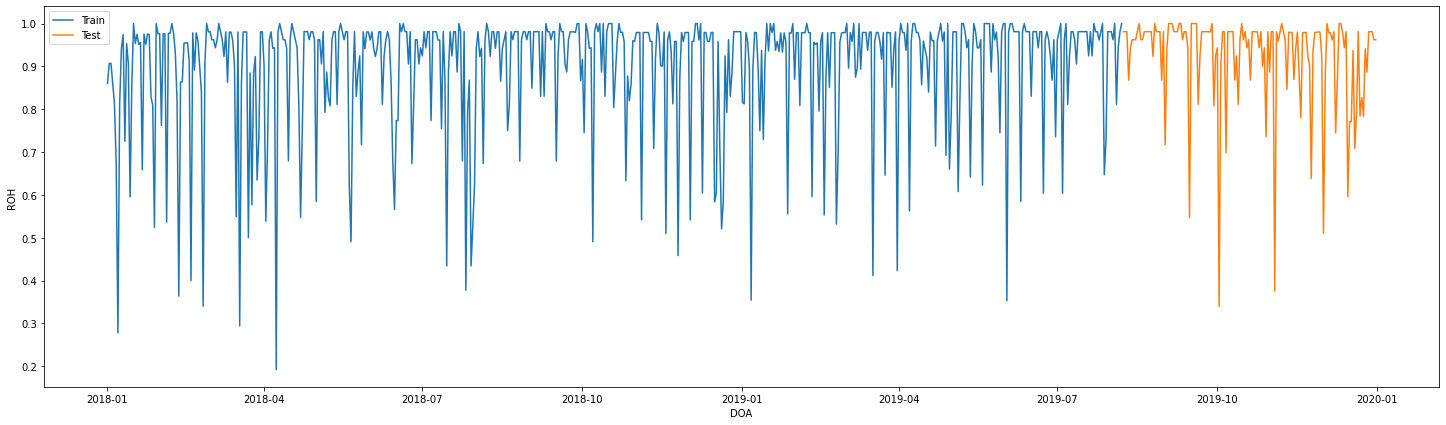

In [4]:
plt.figure(figsize=(25,7))
plt.plot(train.index, train['ROH'], label='Train')
plt.plot(test.index, test['ROH'], label='Test')
plt.xlabel('DOA')
plt.ylabel('ROH')
plt.legend(loc='best')
plt.show()

## 1) Choosing the differencing order
The first step of fitting an ARIMA model is to determine the differencing order to stationarize the series. To do that, we look at the ACF and PACF plots, and keep in mind these two rules:

- Rule 1 : If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing. 
- Rule 2 : If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.” 
(Robert Nau, Statistical Forecasting)

(-2.0, 0.1)

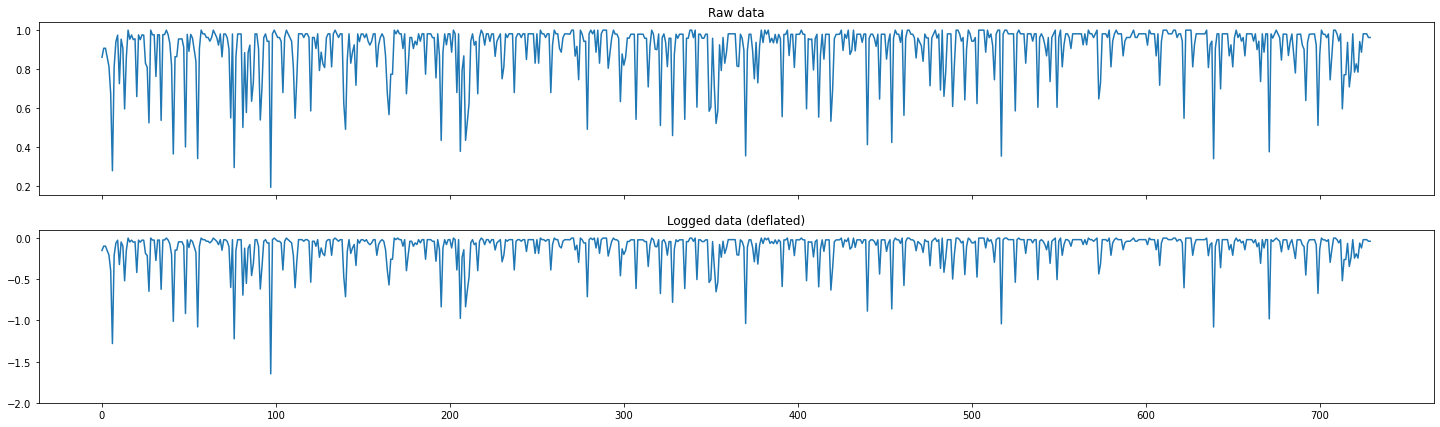

In [5]:
# Raw trends 
fig, ax = plt.subplots(2, sharex=True, figsize=(25,7))
ax[0].plot(df.ROH.values)
ax[0].set_title("Raw data")
ax[1].plot(np.log(df.ROH.values))
ax[1].set_title("Logged data (deflated)")
ax[1].set_ylim(-2, 0.1)

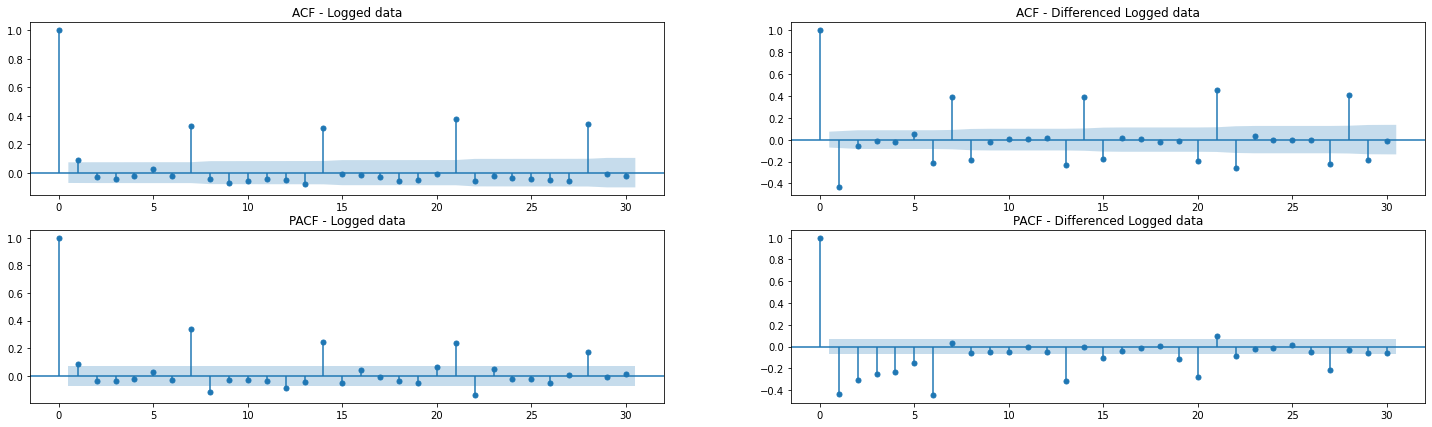

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(25,7))
first_diff = (df.ROH - df.ROH.shift()).dropna()
ax[0, 0] = plot_acf(df.ROH, ax=ax[0, 0], lags=30, title="ACF - Logged data")
ax[1, 0] = plot_pacf(df.ROH, ax=ax[1, 0], lags=30, title="PACF - Logged data")
ax[0, 1] = plot_acf(first_diff , ax=ax[0, 1], lags=30, title="ACF - Differenced Logged data")
ax[1, 1] = plot_pacf(first_diff, ax=ax[1, 1], lags=30, title="PACF - Differenced Logged data")

In [7]:
print(" > Is the data stationary ?")
dftest = kpss(df.ROH, 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))

 > Is the data stationary ?
Test statistic = 0.089
P-value = 0.100
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
/Users/ahmadabdullahtariq/Documents/Projects/thesis/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/ahmadabdullahtariq/Documents/Projects/thesis/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [8]:
model = ARIMA(df.ROH.dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df.ROH.dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

                              ARMA Model Results                              
Dep. Variable:                    ROH   No. Observations:                  730
Model:                     ARMA(0, 0)   Log Likelihood                 410.692
Method:                           css   S.D. of innovations              0.138
Date:                Sun, 14 Mar 2021   AIC                           -817.384
Time:                        13:44:12   BIC                           -808.197
Sample:                    01-01-2018   HQIC                          -813.839
                         - 12-31-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9048      0.005    177.336      0.000       0.895       0.915
                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observat

The Akaike Information Criterion (AIC) is lower with the ARIMA(0,1,0), meaning this model is performing better than the ARIMA(0,0,0). Let’s have a look at the residuals and check their variance:

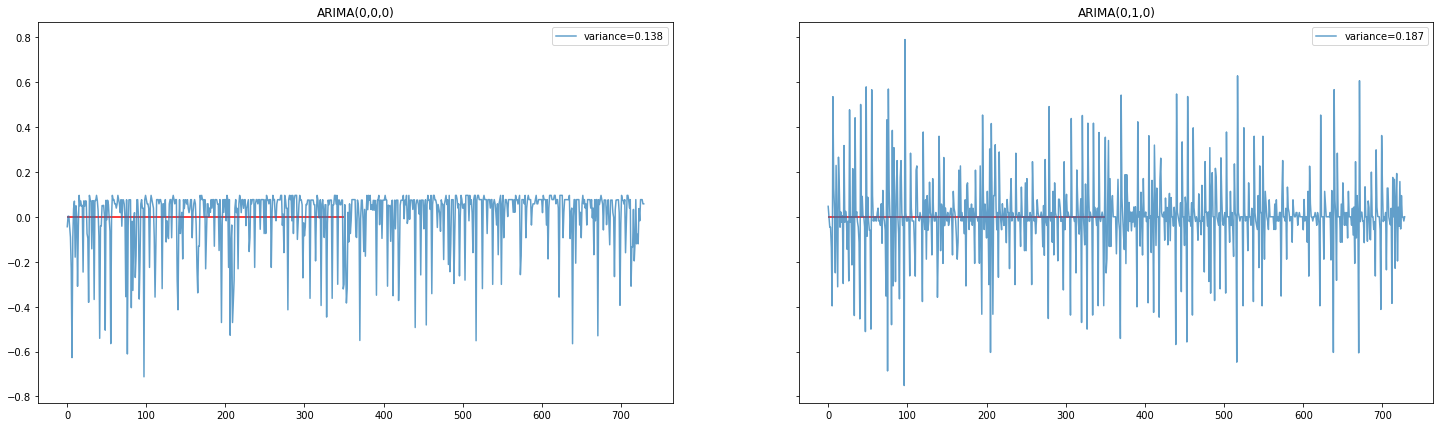

In [9]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(25, 7))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)))
ax[0].hlines(0, xmin=0, xmax=350, color='r')
ax[0].set_title("ARIMA(0,0,0)")
ax[0].legend()
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)))
ax[1].hlines(0, xmin=0, xmax=350, color='r')
ax[1].set_title("ARIMA(0,1,0)")
ax[1].legend()

## 2) Choosing the MA order
- If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1
- Notice how the AIC has dropped again, and how the residuals variance decreased. That’s a sign our (1,1,0) ARIMA is performing better than the (0,1,0) model !

                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observations:                  729
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 266.570
Method:                       css-mle   S.D. of innovations              0.168
Date:                Sun, 14 Mar 2021   AIC                           -527.140
Time:                        13:44:14   BIC                           -513.365
Sample:                    01-02-2018   HQIC                          -521.826
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0001      0.004      0.028      0.978      -0.008       0.009
ar.L1.D.ROH    -0.4358      0.033    -13.091      0.000      -0.501      -0.371
                                    Roots       

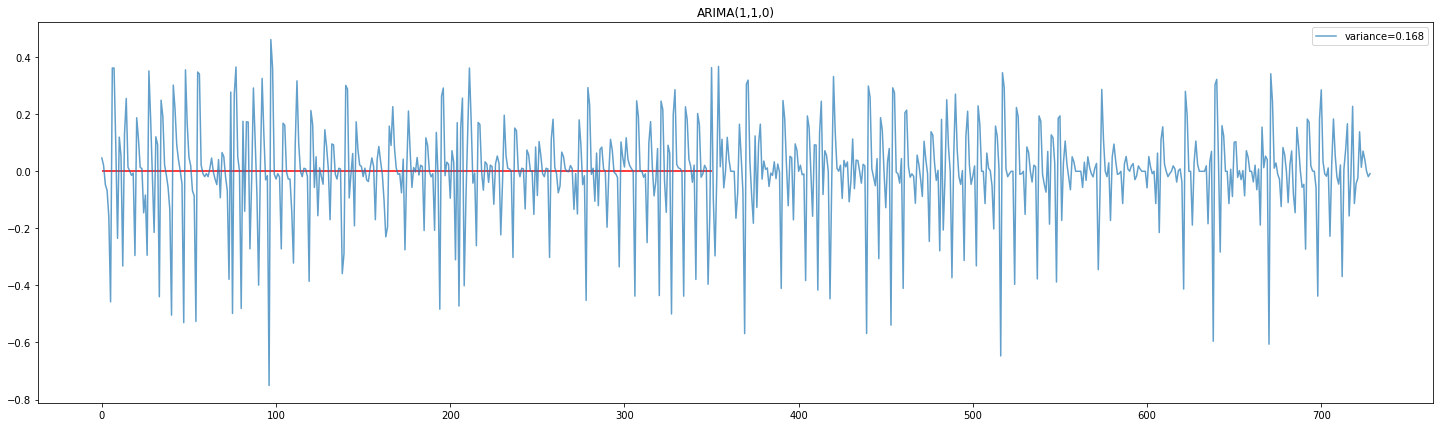

In [10]:
model = ARIMA(df.ROH.dropna(), (1, 1, 0))
res_110 = model.fit()
print(res_110.summary())

fig, ax = plt.subplots(figsize=(25, 7))
ax.plot(res_110.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_110.resid.values)))
ax.hlines(0, xmin=0, xmax=350, color='r')
ax.set_title("ARIMA(1,1,0)")
ax.legend()

# 3) Choosing the AR order
- If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1

                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observations:                  729
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 414.075
Method:                       css-mle   S.D. of innovations              0.137
Date:                Sun, 14 Mar 2021   AIC                           -820.150
Time:                        13:44:15   BIC                           -801.784
Sample:                    01-02-2018   HQIC                          -813.064
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.243e-05   2.58e-05      3.190      0.001    3.18e-05       0.000
ar.L1.D.ROH     0.0724      0.037      1.959      0.050   -4.62e-05       0.145
ma.L1.D.ROH    -1.0000      0.004   -223.551    

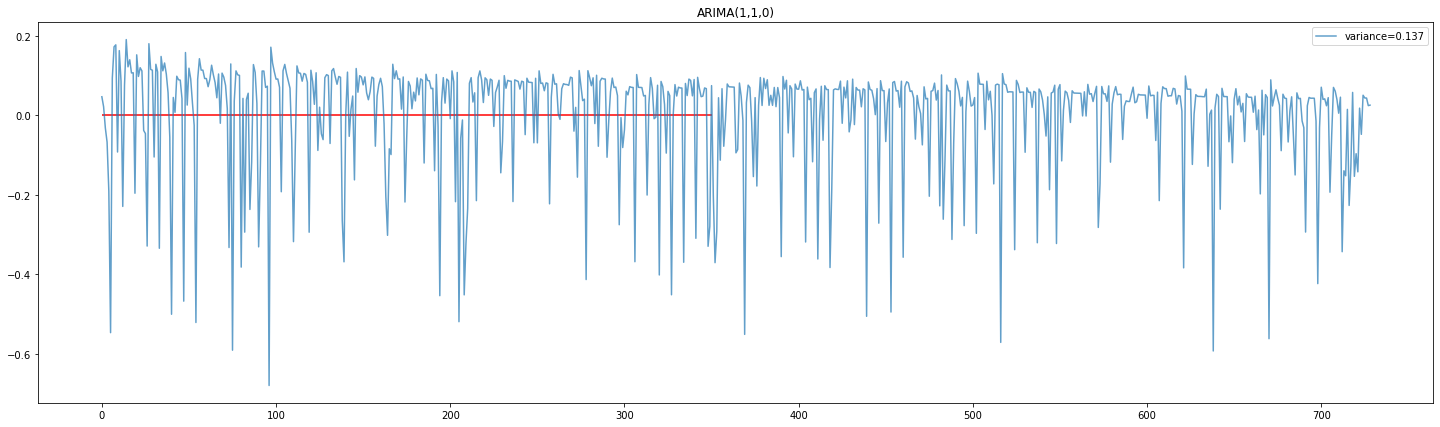

In [11]:
model = ARIMA(df.ROH.dropna(), (1, 1, 1))
res_111 = model.fit()
print(res_111.summary())

fig, ax = plt.subplots(figsize=(25, 7))
ax.plot(res_111.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_111.resid.values)))
ax.hlines(0, xmin=0, xmax=350, color='r')
ax.set_title("ARIMA(1,1,0)")
ax.legend()

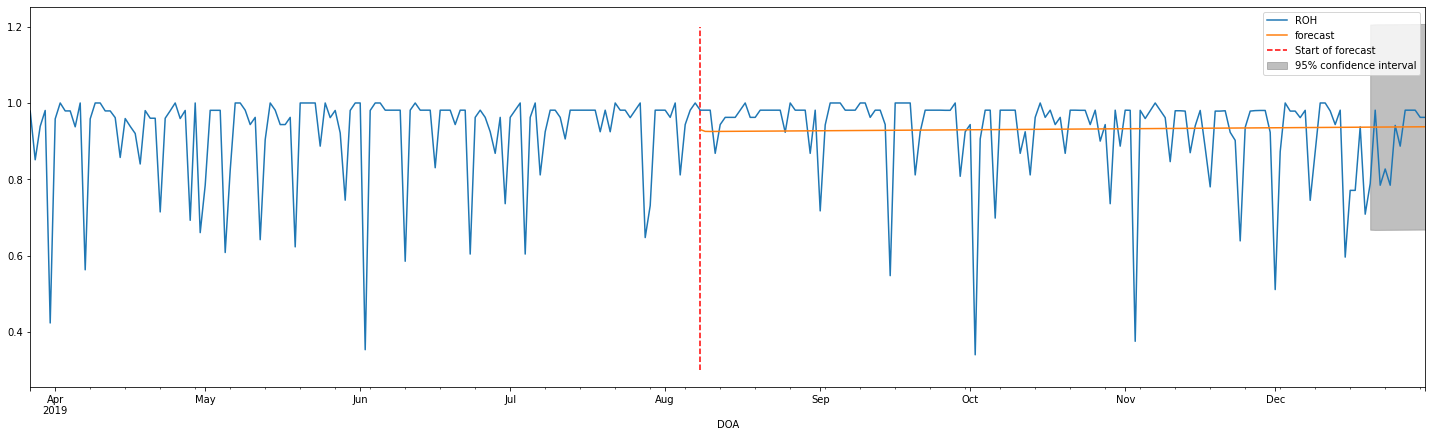

In [12]:
model = ARIMA(df.ROH.dropna()[:-12], (1, 1, 1))
res_111 = model.fit()

fig, ax = plt.subplots(figsize=(25, 7))
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
df.ROH.dropna()[450:].plot(ax=ax)
ax.vlines('2019-08-08', 0.3, 1.2, linestyle='--', color='r', label='Start of forecast')

# # - NOTE from the official documentation :
# # -- The dynamic keyword affects in-sample prediction. 
# # -- If dynamic is False, then the in-sample lagged values are used for prediction. 
# # -- If dynamic is True, then in-sample forecasts are used in place of lagged dependent variables.
ax = res_111.plot_predict('2019-08-08', '2019-12-31', dynamic=True, plot_insample=False, ax=ax)

# SARIMA

<ipython-input-13-07f69b14567b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['station'] = train.ROH - train.ROH.rolling(7).mean()


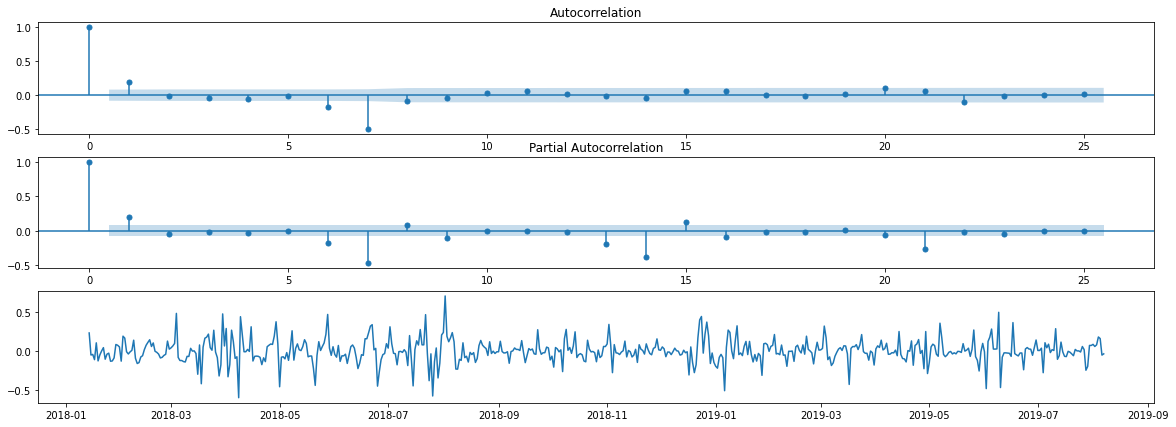

In [13]:
# Stationary data
train['station'] = train.ROH - train.ROH.rolling(7).mean()

fig, ax = plt.subplots(3, figsize=(20,7))
x = (train.station.dropna() - train.station.dropna().shift(7)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_st = train["station"]
sarima_model = SARIMAX(train_st, order=(0, 1, 2), seasonal_order=(0, 1, 2, 7), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

In [15]:
sarima_pred = sarima_fit.get_prediction("2019-08-08", "2019-12-31")
predicted_means = sarima_pred.predicted_mean + train['ROH'].rolling(7).mean().dropna().values[-146:]
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower station'] + train['ROH'].rolling(7).mean().dropna().values[-146:]
upper_bounds = predicted_intervals['upper station'] + train['ROH'].rolling(7).mean().dropna().values[-146:]

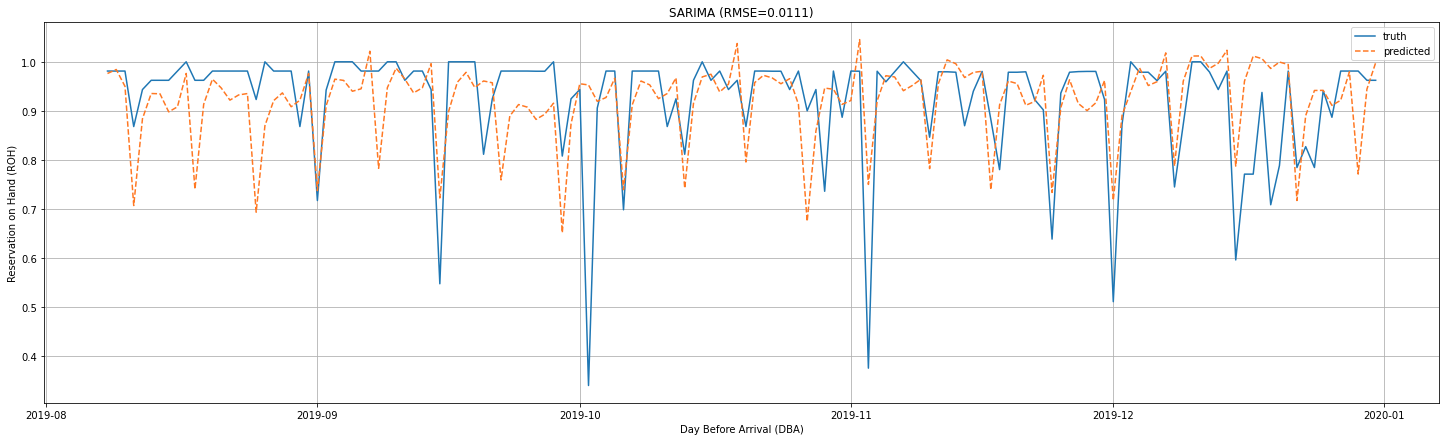

In [16]:
fig, ax = plt.subplots(figsize=(25, 7))
# ax.plot(df.ROH.index[450:-146], df.ROH.values[450:-146])
ax.plot(test['2019-08-08':].index, test['ROH'].values, label='truth')
ax.plot(test['2019-08-08':].index, predicted_means, color='#ff7823', linestyle='--', label="predicted".format(0.1052))
# ax.fill_between(test['2019-08-08':].index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_xlabel('Day Before Arrival (DBA)')
ax.set_ylabel('Reservation on Hand (ROH)')
ax.set_title("SARIMA (RMSE={:0.4f})".format(0.0111))
ax.grid(True)

In [17]:
forecast_accuracy(predicted_means,test['ROH'])

0.105	&	-0.0132	&	0.0691	&	9.1457	&	0.1052	&	0.0111	&	0.141


## Auto Arima 

In [18]:
from pmdarima.arima import ADFTest, auto_arima

In [19]:
df = pd.read_pickle('../dataset/preprocessed/4290_imputed.pkl')
df = preprocess(df)
train, test = train_test_split(df)

In [20]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(train)
# From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

(0.01, False)

In [21]:
auto_arima(train, start_p = 0, d = 1, start_q = 0,
            max_p = 3, max_d = 3, max_q = 3, 
            start_P = 0, D = 1, start_Q = 0, m = 7, seasonal = True,
            error_action = 'warn', trace = True, supress_warnings = True,
            stepwise = True, random_state = 20, n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-243.407, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-479.188, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.57 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-335.379, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-581.873, Time=0.33 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=-690.895, Time=1.05 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=-687.806, Time=0.41 sec
 ARIMA(1,1,0)(2,1,2)[7]             : AIC=-689.413, Time=1.77 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=2.48 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=-608.128, Time=0.48 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=-742.183, Time=1.14 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=-740.277, Time=0.57 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=-631.172, Time=0.56 sec
/Users/ahmadabdullahtariq/Documents/Projects/thesis/.venv/lib/python3.8/site-packages/statsmodels/base/model.

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(2, 1, 1, 7),
      with_intercept=False)

<ipython-input-22-9c7d117616d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['station'] = train.ROH - train.ROH.rolling(7).mean()


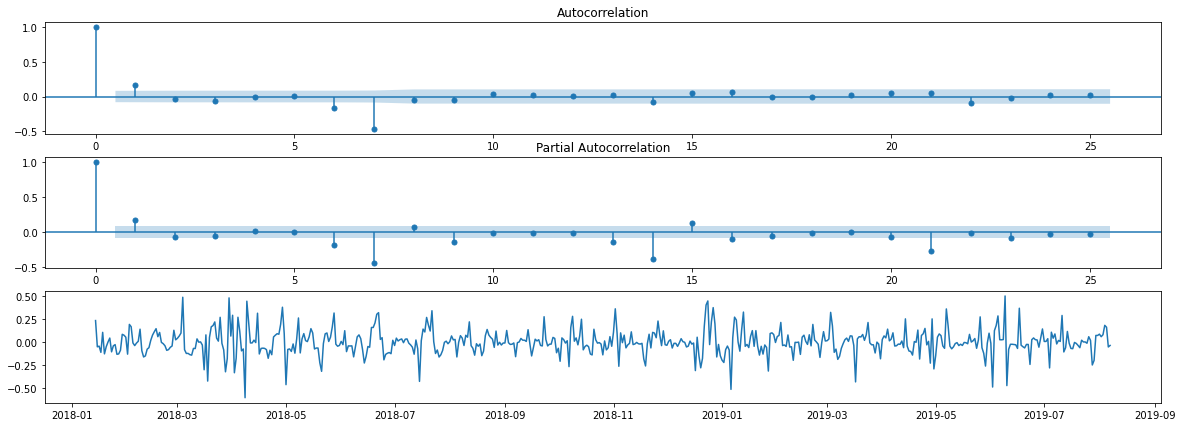

In [22]:
# Stationary data
train['station'] = train.ROH - train.ROH.rolling(7).mean()
train_st = train["station"]

fig, ax = plt.subplots(3, figsize=(20,7))
x = (train.station.dropna() - train.station.dropna().shift(7)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

In [23]:
sarima_model = SARIMAX(train_st, order=(2, 1, 1), seasonal_order=(2, 1, 1, 7), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

In [24]:
sarima_pred = sarima_fit.get_prediction("2019-08-08", "2019-12-31")
predicted_means = sarima_pred.predicted_mean + train['ROH'].rolling(7).mean().dropna().values[-146:]
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower station'] + train['ROH'].rolling(7).mean().dropna().values[-146:]
upper_bounds = predicted_intervals['upper station'] + train['ROH'].rolling(7).mean().dropna().values[-146:]

Text(0.5, 1.0, 'SARIMA')

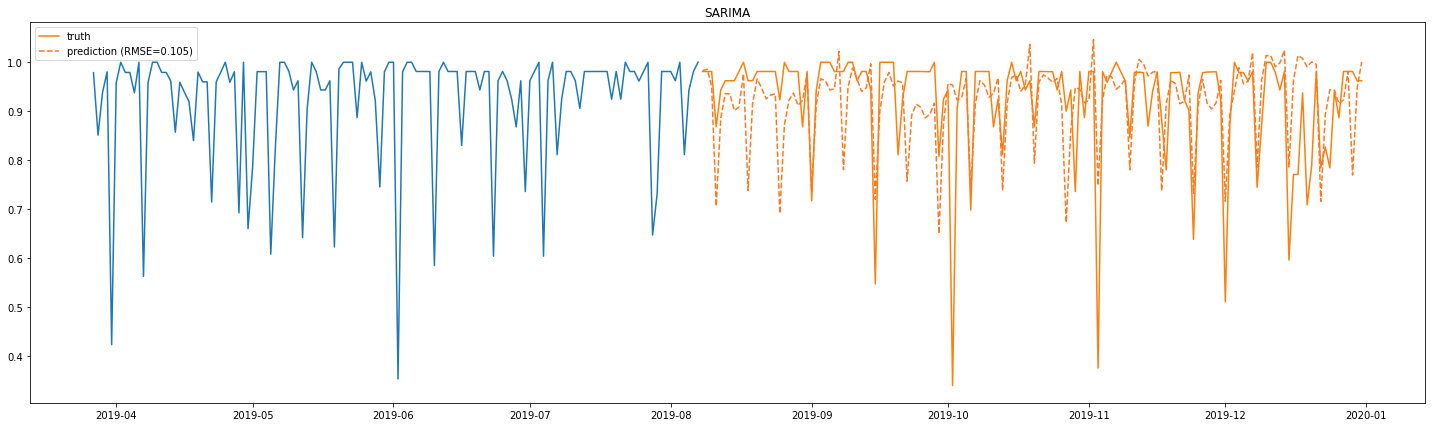

In [25]:
fig, ax = plt.subplots(figsize=(25, 7))
ax.plot(df.ROH.index[450:-146], df.ROH.values[450:-146])
ax.plot(test['2019-08-08':].index, test['ROH'].values, label='truth')
ax.plot(test['2019-08-08':].index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.3f})".format(0.1052))
# ax.fill_between(test['2019-08-08':].index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title("SARIMA")

In [277]:
forecast_accuracy(predicted_means,test['ROH'])

0.1053	&	-0.0144	&	0.0688	&	9.113	&	0.1053	&	0.0111	&	0.1385


In [28]:
df = pd.read_csv('../dataset/results.csv')
df['ARIMA'] = predicted_means.values
df.to_csv('../dataset/results.csv')